In [1]:
import math

import numpy as np
import pandas as pd

In [2]:
def angular_similarity(a, b, normalize=True):
    if normalize:
        norm_a = math.sqrt(sum([ x*x for x in a.values() ]))
        norm_b = math.sqrt(sum([ x*x for x in b.values() ]))

        if norm_a == 0.0 or norm_b == 0.0:
            return 0.0
    else:
        norm_a = 1.0
        norm_b = 1.0

    prod = 0.
    for k, abundance in a.items():
        prod += (float(abundance) / norm_a) * (b.get(k, 0) / norm_b)
    prod = min(1.0, prod)

    distance = 2*math.acos(prod) / math.pi
    return 1.0 - distance        

def angular_similarity_ng(a, b, normalize=True):
    # simulate a as ng
    
    a_sq = 0
    b_sq = sum([ x*x for x in b.values() ])
    
    prod = 0.
    for h, abund in b.items():
        if a.get(h):
            a_sq += 1
            prod += abund * abund
    
    if normalize:
        norm_a = math.sqrt(a_sq)
        norm_b = math.sqrt(b_sq)
        if norm_a == 0.0 or norm_b == 0.0:
            return 0.0
    else:
        norm_a = 1.0
        norm_b = 1.0
    
    prod = min(1.0, prod / (norm_a * norm_b))

    distance = 2*math.acos(prod) / math.pi
    return 1.0 - distance      

In [3]:
a = {40: 10, 50: 5, 99: 1}
b = {40: 2, 50: 2, 100: 10}

In [4]:
angular_similarity(a, b)

0.16558154864938834

In [5]:
angular_similarity(a, {h:1 for h in b})

0.5610031968200676

In [6]:
angular_similarity_ng(a, b)

0.3664329116346875

## Checking if it works

In [7]:
from hypothesis import given, strategies as st, settings, example

EPSILON = 1e-3

In [8]:
samples = []
total_samples = 0

@settings(max_examples=5000)
@given(
    st.dictionaries(st.integers(min_value=1, max_value=10000),
                    st.integers(min_value=1, max_value=255),
                    min_size=100),
    st.dictionaries(st.integers(min_value=1, max_value=10000),
                    st.integers(min_value=1, max_value=255),
                    min_size=100)
)
@example({1: 1, 2: 2}, {1: 1, 2: 2})
@example({1: 1, 2: 1}, {1: 1, 2: 1, 3: 1})
@example({1: 1, 2: 1}, {1: 1})
def test(a, b):
    global total_samples
    a_s = angular_similarity(a, b)
    a_s_ng = angular_similarity_ng(a, b)
    total_samples += 1
    if a_s >= 0.1 and abs(a_s - a_s_ng) > EPSILON:
        samples.append((a_s, a_s_ng, a, b, abs(a_s - a_s_ng)))
    assert a_s <= a_s_ng + EPSILON, (a_s, a_s_ng)

In [9]:
test()

In [10]:
df = pd.DataFrame(samples, columns=["ang sim", "ang sim NG", "a", "b", "diff"])

In [11]:
df.sort_values(by="diff", ascending=False)

,ang sim,ang sim NG,a,b,diff
107,0.100176,1.0,"{6104: 2, 9730: 2, 2828: 2, 836: 2, 8194: 79, ...","{7968: 57, 6814: 226, 6087: 134, 5526: 2, 1026...",0.899824
48,0.100209,1.0,"{1: 42, 2: 2, 256: 1, 2368: 64, 257: 1, 3318: ...","{3456: 1, 1: 1, 3242: 6, 7630: 45, 2131: 1, 87...",0.899791
181,0.100221,1.0,"{5055: 140, 8083: 2, 8710: 2, 2336: 1, 15: 2, ...","{1857: 47, 1: 48, 1721: 2, 2: 2, 5430: 161, 20...",0.899779
8,0.100310,1.0,"{2268: 149, 1: 144, 2620: 251, 256: 192, 1321:...","{6541: 16, 65: 46, 7824: 3, 1343: 1, 61: 198, ...",0.899690
81,0.100407,1.0,"{2: 153, 5561: 35, 261: 13, 6490: 218, 2956: 4...","{3: 50, 6426: 93, 2892: 65, 8193: 68, 513: 199...",0.899593
...,...,...,...,...,...
40,0.339472,1.0,"{1636: 153, 6490: 225, 3342: 240, 8610: 39, 45...","{3149: 100, 5205: 185, 1478: 96, 1992: 46, 751...",0.660528
202,0.350323,1.0,"{515: 211, 1864: 251, 5655: 201, 1093: 186, 34...","{129: 69, 5655: 64, 2892: 148, 7132: 149, 322:...",0.649677
228,0.352186,1.0,"{9616: 172, 9060: 4, 3856: 121, 6747: 117, 366...","{4691: 16, 6104: 60, 836: 77, 4048: 37, 4370: ...",0.647814
187,0.354845,1.0,"{4573: 28, 4948: 170, 9188: 49, 772: 220, 1992...","{5976: 197, 7132: 231, 4948: 37, 1800: 165, 77...",0.645155


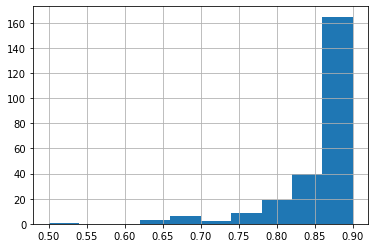

In [12]:
df['diff'].hist()

In [13]:
total_samples

5003

## Fixing a_sq calculation

In [14]:
def angular_similarity_ng_mk2(a, b, normalize=True):
    # simulate a as ng
    
    a_sq = 0
    b_sq = sum([ x*x for x in b.values() ])
    
    prod = 0.
    for h, abund in b.items():
        if a.get(h):
            a_sq += abund * abund
            prod += abund * abund
    
    if normalize:
        norm_a = math.sqrt(a_sq)
        norm_b = math.sqrt(b_sq)
        if norm_a == 0.0 or norm_b == 0.0:
            return 0.0
    else:
        norm_a = 1.0
        norm_b = 1.0
    
    prod = min(1.0, prod / (norm_a * norm_b))

    distance = 2*math.acos(prod) / math.pi
    return 1.0 - distance 

In [15]:
samples_mk2 = []
total_samples = 0

@settings(max_examples=5000)
@given(
    st.dictionaries(st.integers(min_value=1, max_value=10000),
                    st.integers(min_value=1, max_value=255),
                    min_size=100),
    st.dictionaries(st.integers(min_value=1, max_value=10000),
                    st.integers(min_value=1, max_value=255),
                    min_size=100)
)
@example({1: 1, 2: 2}, {1: 1, 2: 2})
@example({1: 1, 2: 1}, {1: 1, 2: 1, 3: 1})
@example({1: 1, 2: 1}, {1: 1})
def test(a, b):
    global total_samples
    a_s = angular_similarity(a, b)
    a_s_ng = angular_similarity_ng_mk2(a, b)
    total_samples += 1
    if a_s >= 0.1 and abs(a_s - a_s_ng) > EPSILON:
        samples_mk2.append((a_s, a_s_ng, a, b, abs(a_s - a_s_ng)))
    assert a_s <= a_s_ng + EPSILON, (a_s, a_s_ng)

In [16]:
test()

In [17]:
df = pd.DataFrame(samples_mk2, columns=["ang sim", "ang sim NG", "a", "b", "diff"])

In [18]:
df.sort_values(by="diff", ascending=False)

,ang sim,ang sim NG,a,b,diff
0,0.500000,1.000000,"{1: 1, 2: 1}",{1: 1},0.500000
69,0.150617,0.611697,"{201: 20, 8193: 2, 4868: 5, 1: 2, 9: 2, 7680: ...","{1665: 29, 273: 1, 1: 3, 8484: 6, 1025: 57, 10...",0.461080
137,0.255547,0.699406,"{7817: 233, 1: 25, 2571: 39, 5269: 215, 8867: ...","{9831: 1, 8160: 236, 1: 26, 7389: 205, 5526: 4...",0.443859
101,0.157636,0.601189,"{4898: 232, 1: 55, 8417: 170, 6426: 1, 8674: 2...","{1: 226, 8867: 1, 7839: 97, 1928: 183, 9124: 1...",0.443552
37,0.112677,0.551372,"{958: 56, 1: 1, 2442: 1, 5783: 1, 6490: 7, 900...","{1: 231, 1157: 1, 4434: 108, 6490: 109, 4177: ...",0.438695
...,...,...,...,...,...
16,0.130911,0.251638,"{9508: 167, 9361: 143, 5590: 2, 1607: 113, 707...","{2057: 36, 5526: 36, 8332: 2, 451: 2, 5333: 23...",0.120727
24,0.333838,0.448930,"{6443: 128, 3277: 1, 1735: 224, 8931: 61, 9510...","{1286: 164, 6554: 139, 9445: 169, 4305: 101, 1...",0.115093
83,0.114431,0.225736,"{8353: 181, 5678: 132, 9445: 52, 7132: 131, 36...","{5508: 241, 8996: 22, 1906: 199, 1800: 154, 53...",0.111305
185,0.123534,0.231124,"{481: 16, 7582: 136, 5512: 65, 439: 136, 1864:...","{836: 180, 419: 229, 3020: 94, 9188: 47, 7646:...",0.107591


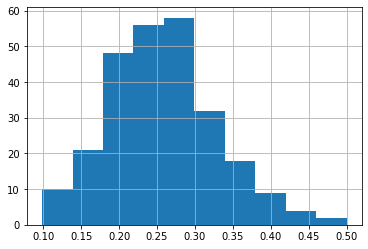

In [19]:
df['diff'].hist()

In [20]:
total_samples

5003